# Tokenização:

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer 

sentences = [
    'i love my dog',
    'I, love my cat',
    'You love my dog!'
]

# num_words vai priorizar as palavras que mais se repetem

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'love': 1, 'my': 2, 'i': 3, 'dog': 4, 'cat': 5, 'you': 6}


Primeiro temos o Tokenizer, ele apenas atribui um numero para cada palavra

# Padding:

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

# Inserimos o OOV para trabalhar com palavras que não estão catalogadas

tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

# O Pad define blocos com o mesmo tamanho para todas as sequencias
padded = pad_sequences(sequences, maxlen=5)
print("\nWord Index = " , word_index)
print("\nSequences = " , sequences)
print("\nPadded Sequences:")
print(padded)


Word Index =  {'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}

Sequences =  [[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]

Padded Sequences:
[[ 0  5  3  2  4]
 [ 0  5  3  2  7]
 [ 0  6  3  2  4]
 [ 9  2  4 10 11]]


In [4]:
padded = pad_sequences(sequences, maxlen=8)
print("\nPadded Sequences:")
print(padded)


Padded Sequences:
[[ 0  0  0  0  5  3  2  4]
 [ 0  0  0  0  5  3  2  7]
 [ 0  0  0  0  6  3  2  4]
 [ 0  8  6  9  2  4 10 11]]


In [8]:
# Testar com dados não catalogados

test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print("\nTest Sequence = ", test_seq)

padded = pad_sequences(test_seq, maxlen=8)
print("\nPadded Test Sequence: ")
print(padded)


Test Sequence =  [[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]

Padded Test Sequence: 
[[0 0 0 5 1 3 2 4]
 [0 0 0 2 4 1 2 1]]


# Treino com Classificação:

In [9]:
import json
import tensorflow as tf

In [11]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [17]:
len(datastore)

26709

In [13]:
sentences[0:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [14]:
labels[0:5]

[0, 0, 1, 1, 0]

In [19]:
training_size = 20000

In [20]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [21]:
vocab_size = 10000
oov_tok = "<OOV>"
max_length = 100
padding_type='post'
trunc_type='post'

In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [23]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [27]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.6720 - accuracy: 0.5634 - val_loss: 0.6214 - val_accuracy: 0.6081 - 2s/epoch - 3ms/step
Epoch 2/30
625/625 - 1s - loss: 0.4723 - accuracy: 0.8002 - val_loss: 0.3960 - val_accuracy: 0.8396 - 1s/epoch - 2ms/step
Epoch 3/30
625/625 - 1s - loss: 0.3192 - accuracy: 0.8738 - val_loss: 0.3716 - val_accuracy: 0.8353 - 1s/epoch - 2ms/step
Epoch 4/30
625/625 - 1s - loss: 0.2622 - accuracy: 0.8967 - val_loss: 0.3444 - val_accuracy: 0.8566 - 1s/epoch - 2ms/step
Epoch 5/30
625/625 - 1s - loss: 0.2262 - accuracy: 0.9117 - val_loss: 0.3510 - val_accuracy: 0.8515 - 1s/epoch - 2ms/step
Epoch 6/30
625/625 - 1s - loss: 0.1990 - accuracy: 0.9235 - val_loss: 0.3563 - val_accuracy: 0.8523 - 1s/epoch - 2ms/step
Epoch 7/30
625/625 - 1s - loss: 0.1752 - accuracy: 0.9338 - val_loss: 0.3634 - val_accuracy: 0.8550 - 1s/epoch - 2ms/step
Epoch 8/30
625/625 - 1s - loss: 0.1576 - accuracy: 0.9413 - val_loss: 0.3794 - val_accuracy: 0.8539 - 1s/epoch - 2ms/step
Epoch 9/30
625/625 - 1s 

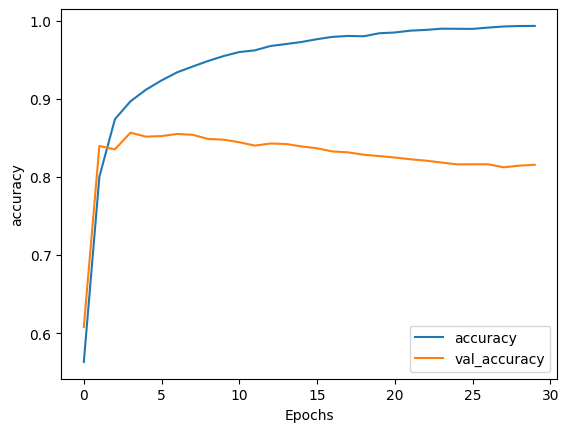

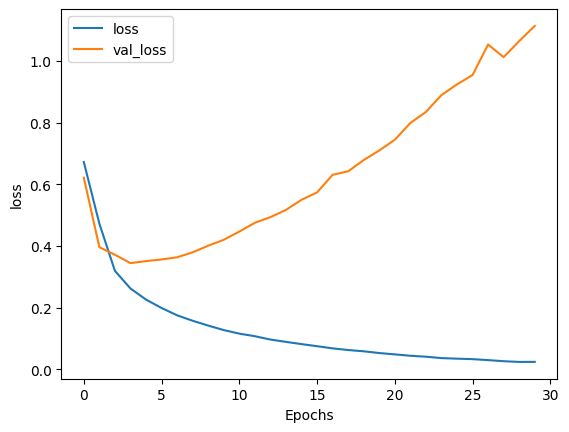

In [28]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [31]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)
# shape: (vocab_size, embedding_dim)

(10000, 16)


In [32]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 76ms/step
[[8.9678144e-01]
 [2.3959792e-06]]


# LSTM:

In [33]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [35]:
tokenizer = Tokenizer()

data = open('irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# print(tokenizer.word_index)
print(total_words)

2690


In [36]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [39]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

8
1
71
6
713
39
1790
1791


In [42]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)

Epoch 1/100
377/377 [==============================] - 13s 26ms/step - loss: 6.7533 - accuracy: 0.0648
Epoch 2/100
377/377 [==============================] - 10s 26ms/step - loss: 6.2458 - accuracy: 0.0764
Epoch 3/100
377/377 [==============================] - 10s 25ms/step - loss: 5.9662 - accuracy: 0.0846
Epoch 4/100
377/377 [==============================] - 10s 27ms/step - loss: 5.6479 - accuracy: 0.1023
Epoch 5/100
377/377 [==============================] - 11s 28ms/step - loss: 5.3068 - accuracy: 0.1185
Epoch 6/100
377/377 [==============================] - 10s 27ms/step - loss: 4.9456 - accuracy: 0.1395
Epoch 7/100
377/377 [==============================] - 11s 29ms/step - loss: 4.5747 - accuracy: 0.1581
Epoch 8/100
377/377 [==============================] - 10s 27ms/step - loss: 4.2152 - accuracy: 0.1852
Epoch 9/100
377/377 [==============================] - 10s 27ms/step - loss: 3.8592 - accuracy: 0.2200
Epoch 10/100
377/377 [==============================] - 10s 27ms/step - l

In [43]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

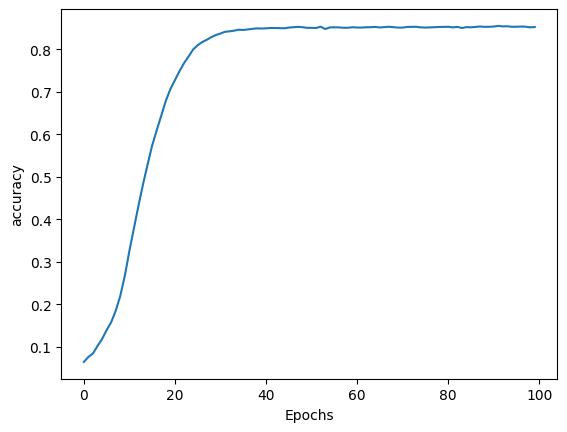

In [44]:
plot_graphs(history, 'accuracy')

In [45]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 20ms/step
I've got a bad feeling about this call waiting for a collar and a tie young love and he had say he had no more bride out by your eyes prison beer died they were mistaken to love my love best now on the rocky road of dublin is green back by by snow and ones was days it were a bride in your eyes are warm away by fray grow but love me for to love me kind and thou free bond art night still my bride for sky fiddlin gem to take a theres desolation rove in the blue mounted the green fainted is green


Biblioteca: music21